In [31]:
import os

In [32]:
import tensorflow as tf

In [34]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        if not tf.config.experimental.get_memory_growth(gpus[0]):
            tf.config.experimental.set_memory_growth(gpus[0], True)
            print("Memory growth set for GPU")
        else:
            print("Memory growth already set for GPU")
    except RuntimeError as e:
        print("Error setting memory growth:", e)
else:
    print("No GPU available")


Error setting memory growth: Physical devices cannot be modified after being initialized


In [23]:
np.random.seed = 42

In [24]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

In [26]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_nuclei.h5',verbose = 1, save_best_only = True)
earlystop =  tf.keras.callbacks.EarlyStopping(patience = 2, monitor='val_loss')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs')
callbacks =[checkpoint, earlystop, tensorboard]

In [7]:
TRAIN_PATH = 'D:/Deep Learning/Nuclei_segmentation/data-science-bowl-2018/stage1_train'
TEST_PATH = 'D:/Deep Learning/Nuclei_segmentation/data-science-bowl-2018/stage1_test'

In [8]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
# it create tuples where 1st entry is parent directory which is stage1_train
# and second element is sub directory
# next returns the next item from the iterator 

In [9]:
train_ids[0] #train_ids contains all the name of files 

'00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'

In [10]:
import numpy as np

In [11]:
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [12]:
# read all the images and resize
# create an empty array and then fill it with images

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),dtype =np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1),dtype =bool)


In [13]:
X_train.shape # 670 are the total subfolders(images)

(670, 128, 128, 3)

In [14]:
Y_train.shape

(670, 128, 128, 1)

In [15]:
#resizing the training images and masks

for n , id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = TRAIN_PATH+'/'+id_
    # print(TRAIN_PATH+'/'+id_)
    # print(path)
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range=True)
    X_train[n] = img # fill X-train with values of images 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH,1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range=True),axis=-1)
        mask = np.maximum(mask,mask_)
    Y_train[n] = mask

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [11:08<00:00,  1.00it/s]


In [17]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

In [18]:
for n , id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + '/' + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.21it/s]


In [19]:
import random

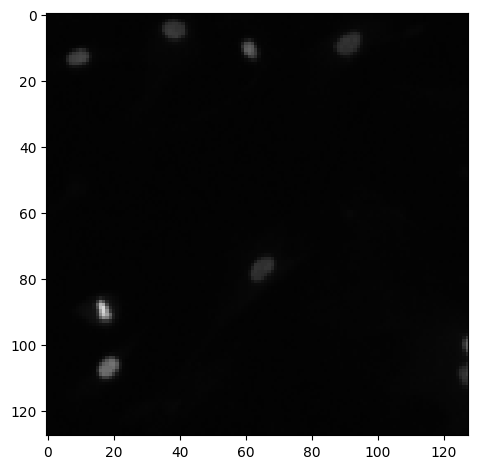

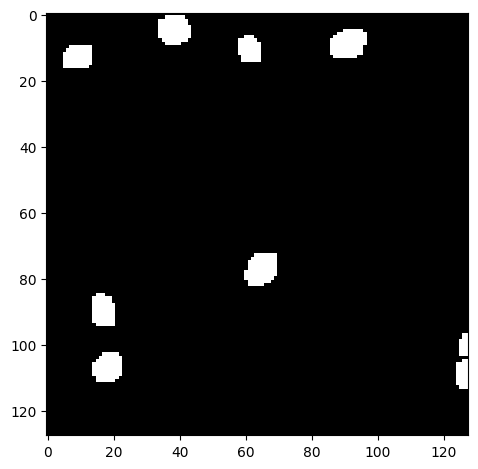

In [20]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [22]:
len(X_train)

670

In [36]:
results = model.fit(X_train, Y_train, validation_split = 0.1, batch_size = 16, epochs = 25, callbacks = callbacks)

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 0.6286 - accuracy: 0.7398
Epoch 1: val_loss improved from inf to 0.44277, saving model to model_nuclei.h5
38/38 [==============================] - 62s 123ms/step - loss: 0.6286 - accuracy: 0.7398 - val_loss: 0.4428 - val_accuracy: 0.8020
Epoch 2/25
37/38 [============================>.] - ETA: 0s - loss: 0.4005 - accuracy: 0.7817
Epoch 2: val_loss improved from 0.44277 to 0.32638, saving model to model_nuclei.h5
38/38 [==============================] - 3s 68ms/step - loss: 0.3971 - accuracy: 0.7836 - val_loss: 0.3264 - val_accuracy: 0.8328
Epoch 3/25
37/38 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.8907
Epoch 3: val_loss improved from 0.32638 to 0.18409, saving model to model_nuclei.h5
38/38 [==============================] - 2s 66ms/step - loss: 0.2552 - accuracy: 0.8915 - val_loss: 0.1841 - val_accuracy: 0.9272
Epoch 4/25
37/38 [============================>.] - ETA: 0s - loss: 0.1949 - a

In [37]:
idx = random.randint(0, len(X_train))


In [40]:
pred_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1 )
pred_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
pred_test = model.predict(X_test, verbose=1)

3/3 [==============================] - 0s 229ms/step


In [41]:
pred_train_t = (pred_train > 0.5).astype(np.uint8)
pred_val_t = (pred_val > 0.5).astype(np.uint8)
pred_test_t = (pred_test > 0.5).astype(np.uint8)

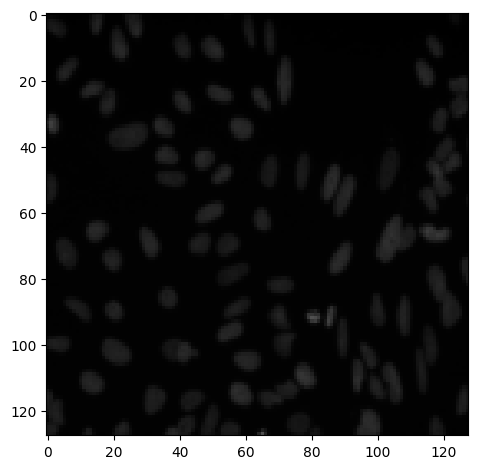

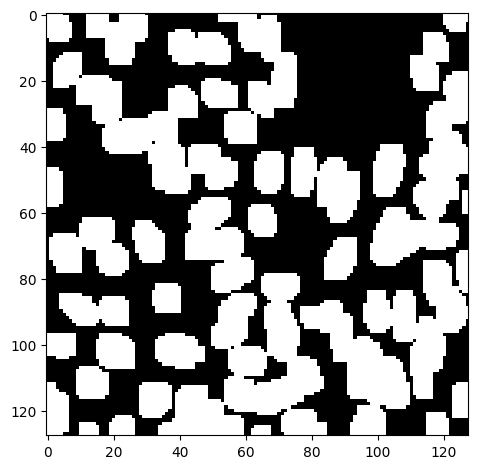

C:\Users\JAY\AppData\Roaming\Python\Python310\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


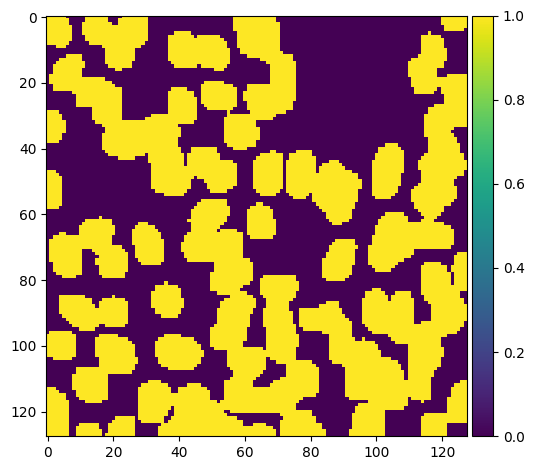

In [42]:
#np.squeeze is used to remove single dimension field from the array 
# sometimes we have extra 1 dimensions which are unneccesary for showing images
# hence we squeeze it as imshow() also needs particular input

ix = random.randint(0, len(pred_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(pred_train_t[ix]))
plt.show()

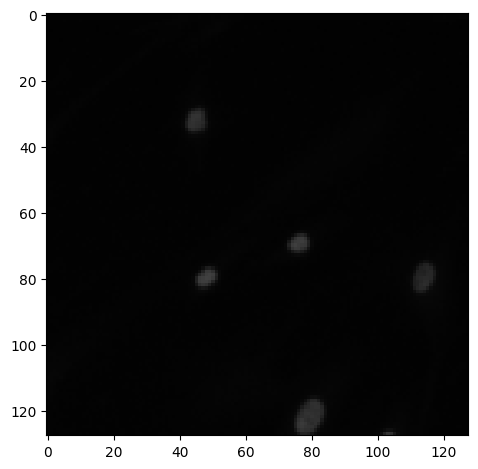

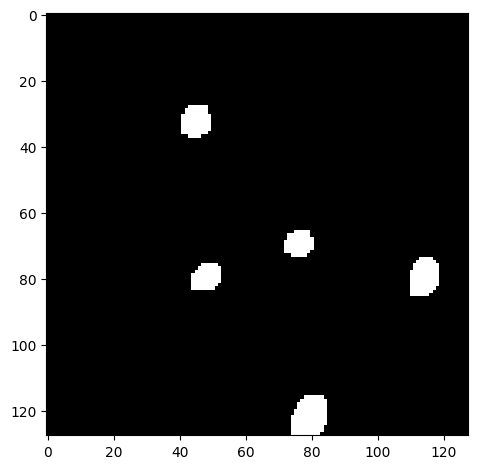

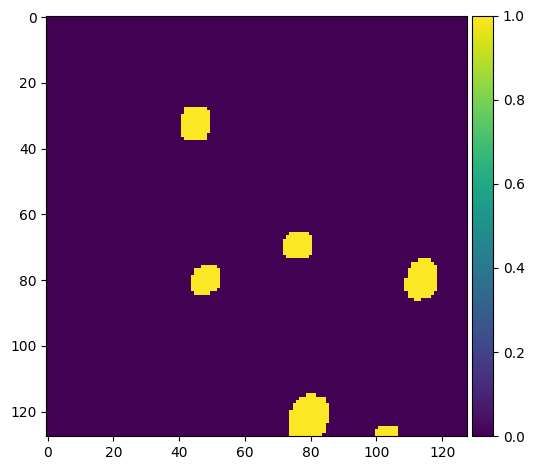

In [46]:
ix = random.randint(0, len(pred_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(pred_val_t[ix]))
plt.show()

In [47]:
def calculate_iou(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [51]:
iou_score = calculate_iou(Y_train[int(Y_train.shape[0]*0.9):][ix], pred_val_t[ix])
print("IoU Score:", iou_score)


IoU Score: 0.8508403361344538
